In [77]:
import os
import time
from collections import defaultdict 
from collections import Counter
import re
import pandas as pd
import numpy as np
import nltk
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

In [48]:
INP_FILE = "data/dowload/IMDB Dataset.csv"
OUT_DIR = "data/data_"

In [3]:
reviews = pd.read_csv(INP_FILE)
reviews.shape

(50000, 2)

In [4]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
reviews.loc[0, "review"]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [7]:
CONTRACTION_LIST = [(r"i'm", "i am"), (r"he's", "he is"), (r"she's", "she is"), (r"it's", "it is"), 
                    (r"that's", "that is"), (r"what\'s", "what is"), (r"where's", "where is"), 
                    (r"how's", "how is"), (r"\'ll", " will"), (r"\'ve", " have"), (r"\'re", " are"), 
                    (r"\'d", " would"), (r"won't", "will not"), (r"can't", "cannot"), (r"n't", " not"),
                    (r"n'", "ng"), (r"\'bout", "about"), (r"\'til", "until"), (r"thats", "that")]


STOP_WORDS = set(nltk.corpus.stopwords.words("english"))
PUNCTUATION = r"[%s]" % re.escape(string.punctuation)

# part of speech tag
POS_TAG = defaultdict(lambda: nltk.corpus.wordnet.NOUN)
POS_TAG["J"] = nltk.corpus.wordnet.ADJ
POS_TAG["N"] = nltk.corpus.wordnet.NOUN
POS_TAG["V"] = nltk.corpus.wordnet.VERB
POS_TAG["R"] = nltk.corpus.wordnet.ADV


def lemmatize(text):
    sentences = nltk.sent_tokenize(text)
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    words = []
    for sent in sentences:
        tokens = sent.split()
        for token, tag in nltk.pos_tag(tokens):
            word = lemmatizer.lemmatize(token, POS_TAG[tag[0]])
            words.append(word)
    return " ".join(words)


def clean_contraction(text, flags=re.IGNORECASE):
    for regex, sub in CONTRACTION_LIST:
        text = re.sub(regex, sub, text, flags=flags)
    return text


def remove_punctuation(text):
    return re.sub(PUNCTUATION, " ", text)

def remove_breaker(text):
    return re.sub(r"<br\s+/>", " ", text)


def clean_text(text):
    text = text.lower()
    
    text = remove_breaker(text)
    
    text = clean_contraction(text)
    
    text = lemmatize(text)
    
    text = remove_punctuation(text)

    tokens = text.split()
    # remove non-alphabetic words
    tokens = [w for w in tokens if w.isalpha()]
    tokens = [w for w in tokens if w not in STOP_WORDS]
    
    # filter out short tokens
    tokens = [w for w in tokens if len(w) > 1]
    
    return " ".join(tokens)

In [49]:
text = reviews.loc[0, "review"]
text

'one reviewer mention watch oz episode hooked right exactly happen first thing strike oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drugs sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealing shady agreement never far away would say main appeal show due fact go show would dare forget pretty picture paint mainstream audiences forget charm forget romance oz mess around first episode ever saw strike nasty surreal could say ready watch develop taste oz get accustom high level graphic violence violence injustice crooked guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz ma

In [50]:
clean_text(text)

'one reviewer mention watch oz episode hook right exactly happen first thing strike oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangstas latinos christian italian irish scuffle death stare dodgy deal shady agreement never far away would say main appeal show due fact go show would dare forget pretty picture paint mainstream audience forget charm forget romance oz mess around first episode ever saw strike nasty surreal could say ready watch develop taste oz get accustom high level graphic violence violence injustice crook guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz may become comfor

In [26]:
start_time = time.time()

reviews["review"] = reviews["review"].apply(clean_text)

end_time = time.time()
elapsed_time = end_time - start_time
print("elapsed_time:", elapsed_time)

elapsed_time: 634.8468835353851


In [32]:
reviews["sentiment"] = reviews["sentiment"].map({"positive": 1, "negative": 0})

In [106]:
reviews["sentiment"].mean()

0.5

In [109]:
reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

In [111]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews["review"], reviews["sentiment"], 
                                                                stratify=reviews["sentiment"],
                                                                test_size=0.2, random_state=21083)

reviews_train, reviews_val, y_train, y_val = train_test_split(reviews_train, y_train,
                                                              stratify=y_train,
                                                              test_size=0.2, random_state=41115)

reviews_train = pd.DataFrame(reviews_train)
reviews_train["sentiment"] = y_train

reviews_val = pd.DataFrame(reviews_val)
reviews_val["sentiment"] = y_val

reviews_test = pd.DataFrame(reviews_test)
reviews_test["sentiment"] = y_test

reviews_train.to_csv(os.path.join(OUT_DIR, "reviews_train.csv"), index=False)
reviews_val.to_csv(os.path.join(OUT_DIR, "reviews_val.csv"), index=False)
reviews_test.to_csv(os.path.join(OUT_DIR, "reviews_test.csv"), index=False)

reviews_train.shape, reviews_val.shape, reviews_test.shape

((32000, 2), (8000, 2), (10000, 2))

In [112]:
all_tokens = []
for text in reviews_train["review"].values:
    all_tokens.extend(text.split())
    
vocab = Counter(all_tokens)
vocab = pd.Series(vocab)
vocab = vocab.sort_values(ascending=False)
vocab.size

80267

In [113]:
vocab[:10]

movie    62893
film     58520
one      35291
like     28181
make     26979
see      24647
good     23091
get      22506
would    20114
time     18873
dtype: int64

In [114]:
vocab[vocab < 10]

castellari    9
crossroad     9
sadler        9
landa         9
milian        9
             ..
wisps         1
boldest       1
hustles       1
ferderal      1
palaver       1
Length: 60090, dtype: int64

In [115]:
vocab[vocab >= 10].count()

20177

In [116]:
n_tokens = []
for text in reviews_train["review"].values:
    n_tokens.append(len(text.split()))

n_tokens = np.array(n_tokens, dtype="int")

print("min:", n_tokens.min())
print("max:", n_tokens.max())
print("mean:", n_tokens.mean())
print("median:", np.median(n_tokens))

min: 3
max: 1399
mean: 118.578875
median: 88.0


Text(0, 0.5, 'count')

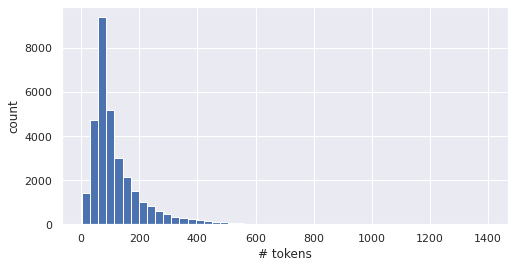

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax.hist(n_tokens, bins=50)
ax.set_xlabel("# tokens")
ax.set_ylabel("count")